In [205]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf
import hvplot.pandas
import seaborn as sns
from pathlib import Path
import requests
import json

import os
import unittest
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from dotenv import load_dotenv
load_dotenv()

True

In [206]:
from alpaca_trade_api import REST


alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


api = REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url="https://paper-api.alpaca.markets"
)

In [288]:
alpha_api = 'GQ3V6KMM3ISFS1NB'

# global variables 
indexes = 'SPY QQQ IWM DIA'
sectors = 'IYC IYH IYK IYR IYZ XLB XLE XLF XLI XLK XLU'
index_plus_sectors = indexes + ' ' + sectors

optionable_stocks_path = Path('./Resources/optionable_stocks.csv')
with open(optionable_stocks_path, 'r') as file:
    optionable_stocks = file.read()
optionable_stocks = optionable_stocks.replace('\n', ' ')

stocks_by_sector = pd.read_csv(Path('./Resources/stocks_by_sector.csv'), index_col='Ticker')

# dates
trading_days_year = 252
total_days_year = 365
thirty_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 30)).date()
ten_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 10)).date()
five_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 5)).date()
three_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 3)).date()
one_year = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 1)).date()
six_months = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year / 2)).date()
yesterday = (pd.Timestamp.today() - pd.Timedelta(days = 1)).date()

date_list = [one_year, five_years_ago, ten_years_ago]
sqrt_252 = np.sqrt(252)

In [453]:
# method for getting close prices on a list of stocks
# important - don't put unnecessary spaces in the tickers, especially if it's a single ticker
def get_close(start, end, tickers = 'spy', interval = '1d'):
    
    if len(tickers) < 5:
        df = yf.Ticker(tickers)
        data = df.history(start=start, end=end, interval = interval)
        data = data['Close']
        data = data.rename(tickers)
    else:
        df = yf.Tickers(tickers)
        data = df.history(start=start, end=end, interval = interval)
        data = data['Close']  
        
    data.index = data.index.date
    return data

# method for getting cumulative return on a stock from a series of close prices
def get_cumprod(series):
    series = series.pct_change()
    series = (series + 1).cumprod()
    series.dropna(inplace= True)
    return series

# get correlation matrix from multiple series
def get_corr(stocks = []):
    all_stocks = pd.concat(stocks, axis=1).dropna()
    all_stocks = all_stocks.corr()
    return all_stocks

# method for getting er dates
def get_er_range(stock, api_key, delta = 10):
    url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={stock}&last=20&apikey={api_key}"
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data['quarterlyEarnings'])
    df= pd.Series(df['reportedDate'])
    # convert the series to a datetime format
    dates = pd.to_datetime(df)
    # create an empty list to hold the new date ranges
    date_ranges = []
    # loop over each date in the series
    for date in dates:
        # create a date range for 10 days before and after the current date
        date_range = pd.date_range(date - pd.Timedelta(days=delta), date + pd.Timedelta(days=delta))
        # convert the date range to a Series object
        date_range_series = pd.Series(date_range)
        # add the date range to the list of date ranges
        date_ranges.append(date_range_series)
    # concatenate the list of date ranges into a single Series object
    new_dates = pd.concat(date_ranges)
    # remove any duplicates and sort the new series
    new_dates = pd.Series(sorted(set(new_dates)))
    # print the new series
    return new_dates


def get_income_statement(stock, api_key):
    url = f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={stock}&last=20&apikey={api_key}"
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data['quarterlyReports'])
    return df

def get_balance_sheet(stock, api_key):
    url = f"https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={stock}&last=20&apikey={api_key}"
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data['quarterlyReports'])
    return df

# returns a df that has cumulative return for a set period for holding a stock vs holding it during er window
def comp_er_window(ticker, start, end, api_key):

    pct = get_close(start = start, end = end, tickers = ticker).pct_change()
    _range = get_er_range(ticker, api_key)

    standard_final = (pct + 1).cumprod().iloc[-1]
    pct = pct.reset_index()


    er_window = pd.concat([_range, pct], axis = 1, join = 'inner').drop('index', axis = 1)
    er_window.set_index(er_window.columns[0], inplace= True)
    er_window.dropna(inplace= True)
    er_final = (er_window + 1).cumprod().iloc[-1].values.astype(float)

    out = pd.DataFrame({
        "Buy and hold": standard_final,
        "Buy During Earnings": er_final
    })
    return out

# get a series of total returns on a weighted portfolio
def portfolio_returns(tickers, weights, start, end):
    portfolio = get_cumprod(get_close(start=start, end = end, tickers = tickers))
    return portfolio.dot(weights)

def get_pctchge(series_pct):
    series_pct = series_pct.pct_change()
    return series_pct

def get_mean(series):
    series_m = series.mean()
    series_m = series_m*252
    
    return series_m
    
def get_std(series):
    series_sd = series.std()
    series_sd = series_sd*np.sqrt(252)
    
    return series_sd

def get_sharpe(series_m, series_sd):
    series_sharpe = (series_m - 0.05) / series_sd
    
    return series_sharpe

def cum_ret_rank(df, i):
    sectors_1_cum = df.iloc[-1:]
    sectors_1_cum = sectors_1_cum.transpose()
    columns = ["Close"]
    sectors_1_cum.columns = columns
    sectors_1_cum["CumRet"] = (sectors_1_cum['Close'] - 1)*100
    sectors_1_cum = sectors_1_cum.sort_values('CumRet', ascending=False)
    sectors_1_cum = sectors_1_cum.drop('Close', axis=1)
    sectors_1_cum.index.rename('Index', inplace=True)

    sectors_1_cum = sectors_1_cum.rename(index={'DIA': 'Dow Ind',
                                                'IWM': 'Russell',
                                                'IYC': 'Cons Disc',
                                                'IYH': 'Healthcare',
                                                'IYK': 'Cons Stple',
                                                'IYR': 'Real Est.',
                                                'IYZ': 'Comm',
                                                'QQQ': 'NASDAQ',
                                                'SPY': 'S&P 500',
                                                'XLB': 'Materials',
                                                'XLE': 'Energy',
                                                'XLF': 'Financials',
                                                'XLI': 'Industrials',
                                                'XLK': 'Technology',
                                                'XLU': 'Utilities'})


    sectors_1_bchart = sectors_1_cum.hvplot.bar(xlabel='Index',
                                                ylabel='CumRet',
                                                color = 'cyan',
                                                hover_color='magenta',
                                                height=500,
                                                width=1000).opts(yformatter='%.0f',
                                                                 title=f'Index and Sector Cumulative Returns Ranking - {i} Year Window')
    return  sectors_1_bchart

def get_metrics(df):
    ind_sec_1y = get_pctchge(df)
    ind_sec_1y_m = get_mean(ind_sec_1y)
    ind_sec_1y_sd = get_std(ind_sec_1y)
    ind_sec_1y_sr = get_sharpe(ind_sec_1y_m, ind_sec_1y_sd)

    ind_sec_1y_m = ind_sec_1y_m.sort_values(ascending=False)
    ind_sec_1y_sd = ind_sec_1y_sd.sort_values(ascending=False)
    ind_sec_1y_sr = ind_sec_1y_sr.sort_values(ascending=False)
    return ind_sec_1y_m, ind_sec_1y_sd, ind_sec_1y_sr

def compare_sharpe(start):
    value_1 = value.set_index('Ticker')
    growth_1 = growth.set_index('Ticker')
    value_close = get_close(start, yesterday, tickers = value_str).pct_change().dropna()
    growth_close = get_close(start, yesterday, tickers = growth_str).pct_change().dropna()
    value_sharpe = (value_close.mean()*252 - 0.05 + value_1['DividendYield']) / (value_close.std()*sqrt_252)
    growth_sharpe = (growth_close.mean()*252 - 0.05 + growth_1['DividendYield']) / (growth_close.std()*sqrt_252)
    growth_p = growth_sharpe.sort_values().tail(5).hvplot.bar(rot = 45,
                                                               label = 'Growth Stocks',
                                                               title = f'Growth vs Value sharpe comp since {start} dividend adjusted',
                                                               color = 'cyan',
                                                               height = 400,
                                                               width = 1000)
    value_p = value_sharpe.sort_values().tail(5).hvplot.bar(rot = 45,
                                                             label = 'Value Stocks',
                                                             color = 'magenta')
    return growth_p * value_p, growth_sharpe.sort_values().tail(5), value_sharpe.sort_values().tail(5)

def get_mc(stk_analysis_df, start, sim_years = 5, combined = True):
    timeframe = "1Day"
    initial_investment = 10000
    df_list = []
    # gives us top 10 stocks by sharpe for that time period
    if combined:
        port = stk_analysis_df.index
    else:
        port = stk_analysis_df
    df_ticker = api.get_bars(port, timeframe, start=start, end=yesterday, limit=1000000).df

    # Display sample data
    for stock in port:
        i = df_ticker[df_ticker["symbol"]==stock].drop("symbol", axis=1)
        df_list.append(i)

    df = pd.concat(df_list, axis=1, keys = port)

    MC_even_dist = MCSimulation(

        portfolio_data=df,

        num_simulation=100,
        num_trading_days=252*sim_years
    )
    tbl = MCSimulation.summarize_cumulative_return(MC_even_dist)

    ci_lower = round(tbl[8] * initial_investment, 2)
    ci_upper = round(tbl[9] * initial_investment, 2)
    
    
    print(f"There is a 95% chance that the investment of {initial_investment} in the range of ${ci_lower} and ${ci_upper}")
    return tbl[1], tbl[2]

In [209]:
sectors_10_daily = get_close(ten_years_ago, yesterday, tickers = index_plus_sectors)
sectors_5_daily = get_close(five_years_ago, yesterday, tickers = index_plus_sectors)
sectors_1_daily = get_close(one_year, yesterday, tickers = index_plus_sectors)

sectors_10 = get_cumprod(sectors_10_daily)
sectors_5 = get_cumprod(sectors_5_daily)
sectors_1 = get_cumprod(sectors_1_daily)

[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed


In [210]:
ind_sec_1y_m, ind_sec_1y_sd, ind_sec_1y_sr = get_metrics(sectors_1_daily)

In [211]:
ind_sec_5y_m, ind_sec_5y_sd, ind_sec_5y_sr = get_metrics(sectors_5_daily)

In [212]:
ind_sec_10y_m, ind_sec_10y_sd, ind_sec_10y_sr = get_metrics(sectors_10_daily)

In [213]:
ind_sec_1y_df = pd.concat([ind_sec_1y_m,  ind_sec_1y_sd, ind_sec_1y_sr], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio"]
ind_sec_1y_df.columns = columns

In [214]:
ind_sec_5y_df = pd.concat([ind_sec_5y_m,  ind_sec_5y_sd, ind_sec_5y_sr], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio"]
ind_sec_5y_df.columns = columns

In [215]:
ind_sec_10y_df = pd.concat([ind_sec_10y_m,  ind_sec_10y_sd, ind_sec_10y_sr], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio"]
ind_sec_10y_df.columns = columns

# Mean Return and STD matrix for Index and Sectors for 1, 5, 10 year data

In [306]:
ind_sec_1y_df.hvplot.scatter(x='Std Dev',
                             y='Mean',
                             color = 'Sharpe Ratio',
                             hover_cols=['index'],
                             legend='right',
                             height=400,
                             width=1000,
                             title='Mean and Standard Deviation 1-Year View of Index & Sector Returns',
                             cmap = 'cool',
                             size = 222)

:Scatter   [Std Dev]   (Mean,Sharpe Ratio,index)

In [307]:
ind_sec_5y_df.hvplot.scatter(x='Std Dev',
                             y='Mean',
                             color = 'Sharpe Ratio',
                             hover_cols=['index'],
                             legend='right',
                             height=400,
                             width=1000,
                             title='Mean and Standard Deviation 5-Year View of Index & Sector Returns',
                             cmap = 'cool',
                             size = 222)

:Scatter   [Std Dev]   (Mean,Sharpe Ratio,index)

In [308]:
ind_sec_10y_df.hvplot.scatter(x='Std Dev',
                              y='Mean',
                              color = 'Sharpe Ratio',
                              cmap = 'cool',
                              hover_cols=['index'],
                              legend='right',
                              height=400,
                              width=1000,
                              title='Mean and Standard Deviation 10-Year View of Index & Sector Returns',
                              size = 222)

:Scatter   [Std Dev]   (Mean,Sharpe Ratio,index)

# Cumulative Returns for Index and Sectors for 1, 5, 10 years 

In [219]:
sectors_1.hvplot().opts(height = 400,
                        width = 1000,
                        title = 'Cumulative Returns for Index & Sectors - 1-year View')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [220]:
sectors_5.hvplot().opts(height = 400,
                        width = 1000,
                        title = 'Cumulative Returns for Index & Sectors - 5-year View')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [221]:
sectors_10.hvplot().opts(height = 400,
                         width = 1000,
                         title = 'Cumulative Returns for Index & Sectors - 10-year View')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

# Cumulative Returns Ranking

In [310]:
cum_ret_rank(sectors_1, 1)

:Bars   [Index]   (CumRet)

In [311]:
cum_ret_rank(sectors_5, 5)

:Bars   [Index]   (CumRet)

In [312]:
cum_ret_rank(sectors_10, 10)

:Bars   [Index]   (CumRet)

# Index and Sector correlation matrix for 1, 5, 10 years

In [234]:
sectors_corr_10 = sectors_10.corr()
sectors_corr_5 = sectors_5.corr()
sectors_corr_1 = sectors_1.corr()

<AxesSubplot:>

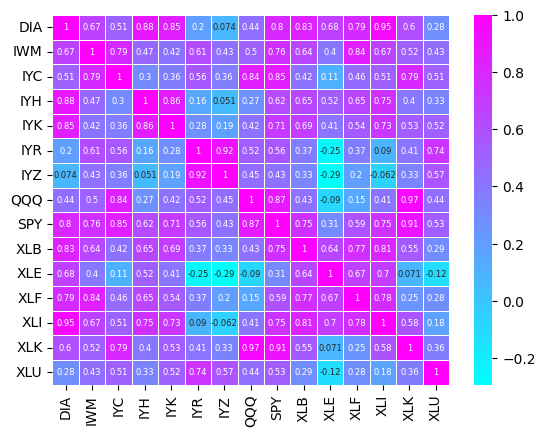

In [468]:
sns.heatmap(sectors_corr_1, cmap = 'cool', linewidth = 0.5, annot = True, annot_kws={"size": 6})

<AxesSubplot:>

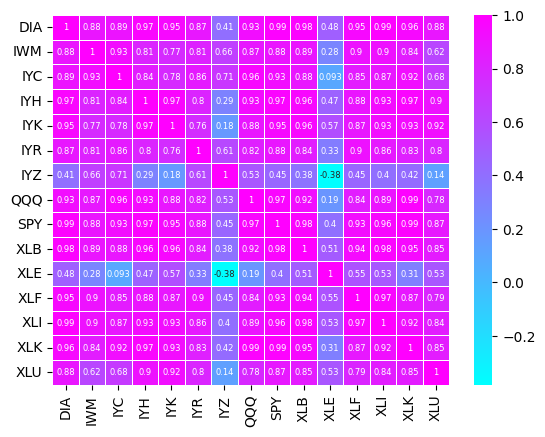

In [469]:
sns.heatmap(sectors_corr_5, cmap = 'cool', linewidth = 0.5, annot = True, annot_kws={"size": 6})

<AxesSubplot:>

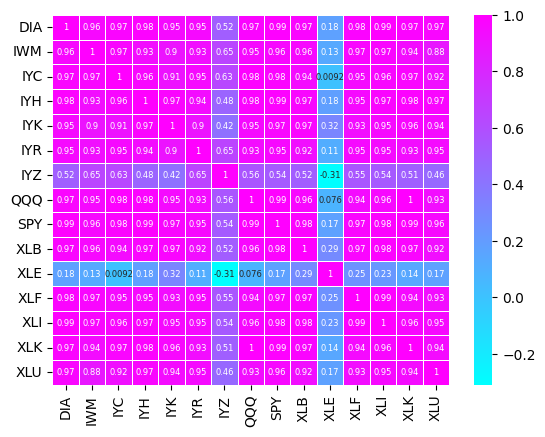

In [470]:
sns.heatmap(sectors_corr_10, cmap = 'cool', linewidth = 0.5, annot = True, annot_kws={"size": 6})

In [225]:
stock_prices = get_close(one_year, yesterday, optionable_stocks)

stk_ret_1y_m, stk_ret_1y_sd , stk_ret_1y_sr = get_metrics(stock_prices)

[*********************100%***********************]  95 of 95 completed


In [226]:
stock_prices = get_close(five_years_ago, yesterday, optionable_stocks)
stk_ret_5y_m, stk_ret_5y_sd , stk_ret_5y_sr = get_metrics(stock_prices)

[*********************100%***********************]  95 of 95 completed


In [227]:
stock_prices = get_close(ten_years_ago, yesterday, optionable_stocks)
stk_ret_10y_m, stk_ret_10y_sd , stk_ret_10y_sr = get_metrics(stock_prices)

[*********************100%***********************]  95 of 95 completed


In [228]:
stk_analysis_1y_df = pd.concat([stk_ret_1y_m,  stk_ret_1y_sd, stk_ret_1y_sr, stocks_by_sector], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio", "Sector"]
stk_analysis_1y_df.columns = columns

In [229]:
stk_analysis_5y_df = pd.concat([stk_ret_5y_m,  stk_ret_5y_sd, stk_ret_5y_sr, stocks_by_sector], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio", "Sector"]
stk_analysis_5y_df.columns = columns

In [230]:
stk_analysis_10y_df = pd.concat([stk_ret_10y_m,  stk_ret_10y_sd, stk_ret_10y_sr, stocks_by_sector], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio", "Sector"]
stk_analysis_10y_df.columns = columns

# Efficient Frontier for optionable stocks for 1, 5, 10 year data

In [273]:
stk_analysis_1y_df.hvplot.scatter(x='Std Dev', y='Mean', color = 'Sharpe Ratio', hover_color='Ticker',
                                  legend='right', height=500, width=1000,
                                  title='Mean and Standard Deviation 1-Year View of Optionable Stock Universe',
                                  hover_cols=['index','Sector'],
                                  size = 77,
                                  cmap = 'cool')

:Scatter   [Std Dev]   (Mean,Sharpe Ratio,index,Sector)

In [274]:
stk_analysis_5y_df.hvplot.scatter(x='Std Dev', y='Mean', color = 'Sharpe Ratio', hover_color='Ticker',
                                  legend='right', height=500, width=1000,
                                  title='Mean and Standard Deviation 5-Year View of Optionable Stock Universe',
                                  hover_cols=['index','Sector'],
                                  size = 77,
                                  cmap = 'cool')

:Scatter   [Std Dev]   (Mean,Sharpe Ratio,index,Sector)

In [330]:
stk_analysis_10y_df.hvplot.scatter(x='Std Dev', y='Mean', color = 'Sharpe Ratio', hover_color='Ticker',
                                  legend='right', height=500, width=1000,
                                  title='Mean and Standard Deviation 10-Year View of Optionable Stock Universe',
                                  hover_cols=['index','Sector'],
                                  size = 77,
                                  cmap = 'cool')

:Scatter   [Std Dev]   (Mean,Sharpe Ratio,index,Sector)

# Top 10 Stock Sharpe Ratios for each time period

In [328]:
stk_analysis_1y_shr = stk_analysis_1y_df['Sharpe Ratio'].sort_values(ascending=False)
stk_analysis_1y_shr_h = stk_analysis_1y_shr.head(10)
stk_analysis_1y = stk_analysis_1y_shr_h.hvplot.bar(xlabel='Stock',
                                                   ylabel='Sharpe Ratio',
                                                   ylim=(0.5, 2),
                                                   height=400,
                                                   width=1000,
                                                   color = 'cyan',
                                                   hover_color = 'magenta').opts(yformatter='%.0f',
                                                                                 title='Top 10 Sharpe Ratio Optionable Stocks Ranking - 1 Year Window')
stk_analysis_1y

:Bars   [index]   (Sharpe Ratio)

In [327]:
stk_analysis_5y_shr = stk_analysis_5y_df['Sharpe Ratio'].sort_values(ascending=False)
stk_analysis_5y_shr_h = stk_analysis_5y_shr.head(10)
stk_analysis_5y = stk_analysis_5y_shr_h.hvplot.bar(xlabel='Stock',
                                                   ylabel='Sharpe Ratio',
                                                   ylim=(0.5, 1),
                                                   height=400,
                                                   width=1000,
                                                   color = 'cyan',
                                                   hover_color = 'magenta').opts(yformatter='%.0f',
                                                                                 title='Top 10 Sharpe Ratio Optionable Stocks Ranking - 5 Year Window')
stk_analysis_5y

:Bars   [index]   (Sharpe Ratio)

In [326]:
stk_analysis_10y_shr = stk_analysis_10y_df['Sharpe Ratio'].sort_values(ascending=False)
stk_analysis_10y_shr_h = stk_analysis_10y_shr.head(10)
stk_analysis_10y = stk_analysis_10y_shr_h.hvplot.bar(xlabel='Stock',
                                                     ylabel='Sharpe Ratio',
                                                     ylim=(0.5, 1.2),
                                                     height=400,
                                                     width=1000,
                                                     color = 'cyan',
                                                     hover_color = 'magenta').opts(yformatter='%.0f',
                                                                                   title='Top 10 Sharpe Ratio Optionable Stocks Ranking - 10 Year Window')
stk_analysis_10y

:Bars   [index]   (Sharpe Ratio)

# Earnings analysis 

In [289]:
stocks_by_sector.reset_index(inplace=True)
stocks_grouped = stocks_by_sector.groupby('Sector').count()
stocks_grouped.hvplot.bar(rot = 35,
                         width = 1000,
                         height = 400,
                         color = 'cyan',
                         hover_color = 'magenta')

:Bars   [Sector]   (Ticker)

In [291]:
dividend_yield = []
pe_ratio = []
for stock in stocks_by_sector['Ticker']:
    try:
        ticker = yf.Ticker(stock)
        try:
            pe = ticker.info['trailingPE']
        except KeyError:
            pe = 0
        
        try:
            dyield = ticker.info['dividendYield']
        except KeyError:
            dyield = 0
        
        dividend_yield.append(dyield)
        pe_ratio.append(pe)
    
    except:
        dividend_yield.append(None)
        pe_ratio.append(None)
    
    
stocks_by_sector['DividendYield'] = dividend_yield
stocks_by_sector['PERatio'] = pe_ratio
print('done')

done


In [332]:
stocks_by_sector.hvplot.scatter(x='DividendYield',
                                y= 'PERatio',
                                color = 'DividendYield',
                                cmap = 'cool',
                                hover_cols=['Ticker'],
                                title = 'Optionable stocks universe PE Ratio/Dividend Yield matrix',
                                ylim = (-20,200),
                                width = 1000,
                                height = 400,
                                size = 77)

:Scatter   [DividendYield]   (PERatio,Ticker)

In [244]:
value = stocks_by_sector[(stocks_by_sector['DividendYield'] > 0.02) & (stocks_by_sector['PERatio'] < 15)]
growth = stocks_by_sector[(stocks_by_sector['DividendYield'] < 0.02) & (stocks_by_sector['PERatio'] > 15)]

In [348]:
growth_p = growth.groupby('Sector').size().hvplot.bar(rot = 45,
                                                      label = 'Growth',
                                                      color = 'cyan',
                                                      width = 1000,
                                                      height = 400)
value_p = value.groupby('Sector').size().hvplot.bar(rot = 45,
                                                    alpha = 1,
                                                    label = 'Value',
                                                    title = 'Count of Value vs Growth portfolio stocks by sector',
                                                    color = 'magenta')

In [349]:
growth_p * value_p

:Overlay
   .Bars.Growth :Bars   [Sector]   (0)
   .Bars.Value  :Bars   [Sector]   (0)

In [324]:
value_ps = value.hvplot.scatter(x='DividendYield',
                                y= 'PERatio',
                                color = 'magenta',
                                hover_cols=['Ticker'],
                                label = 'Value',
                                title = 'Growth vs Value fundamentals distribution',
                                ylim = (-20,200),
                                width = 1000,
                                height = 400,
                                size = 111)
growth_ps = growth.hvplot.scatter(x='DividendYield',
                                  y= 'PERatio',
                                  color = 'cyan',
                                  hover_cols=['Ticker'],
                                  label = 'Growth',
                                  width = 1000,
                                  height = 400,
                                  size = 111)

In [325]:
growth_ps * value_ps

:Overlay
   .Scatter.Growth :Scatter   [DividendYield]   (PERatio,Ticker)
   .Scatter.Value  :Scatter   [DividendYield]   (PERatio,Ticker)

In [261]:
value_str = ''
growth_str = ''
for ticker in value['Ticker']:
    value_str += f'{ticker} '
    
for ticker in growth['Ticker']:
    growth_str += f'{ticker} '

In [262]:
for date in date_list:
    value_ret = get_cumprod(get_close(date, yesterday, tickers = value_str))
    growth_ret = get_cumprod(get_close(date, yesterday, tickers = growth_str))
    value_ret = value_ret.iloc[-1].mean()
    growth_ret = growth_ret.iloc[-1].mean()
    print(f'\n Based on returns since {date}, value stocks returned {round(value_ret, 2)} on average vs growth stocks return of {round(growth_ret,2)}\n')

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed

 Based on returns since 2022-05-09, value stocks returned 0.9 on average vs growth stocks return of 1.12

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed

 Based on returns since 2018-05-10, value stocks returned 1.25 on average vs growth stocks return of 2.34

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed

 Based on returns since 2013-05-11, value stocks returned 2.16 on average vs growth stocks return of 8.92



In [381]:
sharpe_1yr, growth_1yr, value_1yr = compare_sharpe(one_year)
sharpe_1yr

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed


:Overlay
   .Bars.Growth_Stocks :Bars   [index]   (0)
   .Bars.Value_Stocks  :Bars   [index]   (0)

In [384]:
sharpe_5yr, growth_5yr, value_5yr = compare_sharpe(five_years_ago)
sharpe_5yr

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed


:Overlay
   .Bars.Growth_Stocks :Bars   [index]   (0)
   .Bars.Value_Stocks  :Bars   [index]   (0)

In [385]:
sharpe_10yr, growth_10yr, value_10yr = compare_sharpe(ten_years_ago)
sharpe_10yr

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed


:Overlay
   .Bars.Growth_Stocks :Bars   [index]   (0)
   .Bars.Value_Stocks  :Bars   [index]   (0)

In [454]:
stk_1yr_mean, stk_1yr_std = get_mc(stk_analysis_1y_shr_h, one_year, 5)
stk_5yr_mean, stk_5yr_std = get_mc(stk_analysis_5y_shr_h, five_years_ago, 5)
stk_10yr_mean, stk_10yr_std = get_mc(stk_analysis_10y_shr_h, ten_years_ago, 5)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
There is a 95% chance that the investment of 10000 in the range of $74260.33 and $191277.96
Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
There is a 95% chance that the investment of 10000 in the range of $32

In [455]:
value_1yr_mean, value_1yr_std = get_mc(value_1yr, one_year, 5)
growth_1yr_mean, growth_1yr_std = get_mc(growth_1yr, one_year, 5)
value_5yr_mean, value_5yr_std = get_mc(value_5yr, five_years_ago, 5)
growth_5yr_mean, growth_5yr_std = get_mc(growth_5yr, five_years_ago, 5)
value_10yr_mean, value_10yr_std = get_mc(value_10yr, ten_years_ago, 5)
growth_10yr_mean, growth_10yr_std = get_mc(growth_10yr, ten_years_ago, 5)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
There is a 95% chance that the investment of 10000 in the range of $11472.61 and $38834.85
Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
There is a 95% chance that the investment of 10000 in the range of $572

In [456]:
df = {'mean_ret' : [ stk_1yr_mean,
             stk_5yr_mean,
             stk_10yr_mean,
             value_1yr_mean,
             growth_1yr_mean,
             value_5yr_mean,
             growth_5yr_mean,
            value_10yr_mean,
            growth_10yr_mean], 
'std_ret' : [stk_1yr_std,
            stk_5yr_std,
            stk_10yr_std,
            value_1yr_std,
            growth_1yr_std,
            value_5yr_std,
            growth_5yr_std,
            value_10yr_std,
            growth_10yr_std]}
index = ['stk_1yr',
            'stk_5yr',
            'stk_10yr',
            'value_1yr',
            'growth_1yr',
            'value_5yr',
            'growth_5yr',
           'value_10yr',
            'growth_10yr']
portfolios = pd.DataFrame(df, index=index)

In [457]:

portfolios['mean_ret'] = portfolios['mean_ret']*100/5 - 5
portfolios['std_ret'] = portfolios['std_ret']*sqrt_252
portfolios['sharpe'] = portfolios['mean_ret'] / portfolios['std_ret']

In [463]:
portfolios.hvplot.scatter(x = 'std_ret',
                         y = 'mean_ret',
                         color = 'sharpe',
                         cmap = 'cool',
                         size = 222,
                         title = 'Comp of overall best stock portfolios vs growth and value separated portfolios',
                         hover_cols = ['index'],
                         width = 1000,
                         height = 400)

:Scatter   [std_ret]   (mean_ret,sharpe,index)

In [466]:
portfolios.sort_values('sharpe', ascending=False)

,mean_ret,std_ret,sharpe
stk_1yr,236.358385,54.384070,4.346096
value_10yr,33.046215,9.341958,3.537397
value_1yr,37.634245,11.186129,3.364367
growth_1yr,282.753551,98.817240,2.861379
value_5yr,46.181387,16.582432,2.784959
growth_5yr,98.360965,40.605934,2.422330
stk_5yr,227.717547,94.884732,2.399939
growth_10yr,135.077477,78.130990,1.728859
stk_10yr,304.863518,233.573271,1.305216
